# Projet 2 - NLP : Génération de texte

## Étape 1 : Préparation du corpus

In [1]:
# 1. Importer les librairies
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from collections import Counter

# Télécharger les ressources NLTK si besoin
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mmf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
#2. Charger et prévisualiser le corpus
with open('data/poems.txt', 'r', encoding='utf-8') as f:
    text = f.read()

print("Aperçu du corpus :")
print(text[:500])

Aperçu du corpus :
Two roads diverged in a yellow wood,
And sorry I could not travel both
And be one traveler, long I stood
And looked down one as far as I could
To where it bent in the undergrowth;

I wandered lonely as a cloud
That floats on high o'er vales and hills,
When all at once I saw a crowd,
A host, of golden daffodils;
Beside the lake, beneath the trees,
Fluttering and dancing in the breeze.

Hope is the thing with feathers
That perches in the soul,
And sings the tune without the words,
And never stops 


## Étape 2 : Tokenisation et vocabulaire

In [3]:
#3. Tokenisation
tokens = word_tokenize(text)
print(f"Nombre de tokens : {len(tokens)}")
print(f"Premiers 20 tokens : {tokens[:20]}")

Nombre de tokens : 153
Premiers 20 tokens : ['Two', 'roads', 'diverged', 'in', 'a', 'yellow', 'wood', ',', 'And', 'sorry', 'I', 'could', 'not', 'travel', 'both', 'And', 'be', 'one', 'traveler', ',']


In [4]:
# 4. Construire le vocabulaire et les mappings
vocab = sorted(set(tokens))
print(f"Taille du vocabulaire : {len(vocab)}")

token_to_idx = {tok: idx for idx, tok in enumerate(vocab)}
idx_to_token = {idx: tok for tok, idx in token_to_idx.items()}

# Exemple de conversion tokens → indices
indices = [token_to_idx[tok] for tok in tokens[:10]]
print(f"Indices exemple : {indices}")

Taille du vocabulaire : 101
Indices exemple : [17, 69, 40, 51, 19, 99, 97, 0, 6, 75]


10 tokens les plus fréquents : [(',', 10), ('the', 9), ('And', 6), ('I', 6), ('a', 5), ('in', 4), ('as', 3), (';', 3), ('and', 3), ('all', 3)]


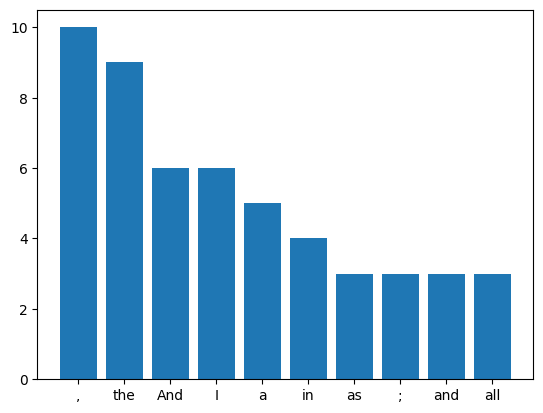

In [5]:
# 5. Analyse simple : fréquence des tokens
counter = Counter(tokens)
most_common = counter.most_common(10)
print("10 tokens les plus fréquents :", most_common)

words, counts = zip(*most_common)
plt.bar(words, counts)
plt.show()

In [6]:
# 6. Préparer les séquences pour le modèle
# Taille des séquences d'entrée
seq_length = 5

# Conversion complète des tokens en indices
indices = [token_to_idx[tok] for tok in tokens]

# Préparer les séquences d'entrée (X) et la cible (Y)
inputs = []
targets = []
for i in range(len(indices) - seq_length):
    inputs.append(indices[i:i+seq_length])
    targets.append(indices[i+seq_length])

print(f"Exemple d'entrée (indices) : {inputs[0]}")
print(f"Exemple de cible (index) : {targets[0]}")

Exemple d'entrée (indices) : [17, 69, 40, 51, 19]
Exemple de cible (index) : 99


In [7]:
# 7. Dataset et DataLoader PyTorch
class TextDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx]), torch.tensor(self.targets[idx])

dataset = TextDataset(inputs, targets)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [8]:
# 8. Définir un modèle RNN simple
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, x):
        embedded = self.embedding(x)
        out, _ = self.rnn(embedded)
        out = out[:, -1, :]  # dernière sortie RNN
        out = self.fc(out)
        return out

vocab_size = len(vocab)
embedding_dim = 32
hidden_dim = 64

model = RNNModel(vocab_size, embedding_dim, hidden_dim)

In [9]:
# 9. Entraînement rapide
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

epochs = 5
for epoch in range(epochs):
    total_loss = 0
    for batch_inputs, batch_targets in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(dataloader):.4f}")

Epoch 1/5 - Loss: 4.6339
Epoch 2/5 - Loss: 4.4774
Epoch 3/5 - Loss: 4.3450
Epoch 4/5 - Loss: 4.2117
Epoch 5/5 - Loss: 4.0982


In [10]:
# 10. Génération de texte simple
def generate_text(model, start_seq, idx_to_token, token_to_idx, length=20):
    model.eval()
    generated = start_seq.copy()
    
    for _ in range(length):
        # Préparer la séquence en indices
        seq_indices = [token_to_idx.get(tok, 0) for tok in generated[-seq_length:]]
        seq_tensor = torch.tensor(seq_indices).unsqueeze(0)  # batch=1
        
        with torch.no_grad():
            output = model(seq_tensor)
            prob = nn.functional.softmax(output, dim=1)
            next_idx = torch.multinomial(prob, num_samples=1).item()
            next_tok = idx_to_token[next_idx]
            generated.append(next_tok)
    
    return ' '.join(generated)

# Exemple d'utilisation :
start_seq = tokens[:seq_length]
print("Texte généré :")
print(generate_text(model, start_seq, idx_to_token, token_to_idx, length=30))

Texte généré :
Two roads diverged in a Shall , trees tune wood When That more . May crowd lake lovely where in That undergrowth I wandered feathers ; crowd all looked where never it floats sorry darling


In [11]:
# Préparer les séquences d’entraînement (input / target) pour génération de texte
# Taille des séquences (exemple 5 tokens par séquence)
seq_length = 5

# Préparer les séquences (X) et les cibles (Y)
input_sequences = []
target_tokens = []

for i in range(len(tokens) - seq_length):
    seq_in = tokens[i:i + seq_length]
    seq_out = tokens[i + seq_length]
    input_sequences.append([token_to_idx[tok] for tok in seq_in])
    target_tokens.append(token_to_idx[seq_out])

print(f"Nombre de séquences: {len(input_sequences)}")
print(f"Exemple de séquence (indices): {input_sequences[0]}")
print(f"Token cible pour cette séquence: {target_tokens[0]} ({idx_to_token[target_tokens[0]]})")


Nombre de séquences: 148
Exemple de séquence (indices): [17, 69, 40, 51, 19]
Token cible pour cette séquence: 99 (yellow)


In [12]:
#Créer un Dataset et DataLoader PyTorch
import torch
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = torch.tensor(inputs, dtype=torch.long)
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

dataset = TextDataset(input_sequences, target_tokens)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [13]:
#Définir un modèle RNN simple avec embeddings
import torch.nn as nn

class SimpleRNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)               # (batch, seq_len, embed_dim)
        output, hidden = self.rnn(x)       # output: (batch, seq_len, hidden_dim)
        out = self.fc(output[:, -1, :])    # prendre sortie du dernier pas de temps
        return out

vocab_size = len(vocab)
embed_dim = 64
hidden_dim = 128
model = SimpleRNNModel(vocab_size, embed_dim, hidden_dim)


In [14]:
#Configurer la fonction de perte et l’optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [15]:
#Entraîner le modèle (exemple de boucle sur 10 epochs)
epochs = 10
model.train()

for epoch in range(epochs):
    total_loss = 0
    for batch_inputs, batch_targets in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.4f}")


Epoch 1/10, Loss: 4.6261
Epoch 2/10, Loss: 4.3611
Epoch 3/10, Loss: 4.1300
Epoch 4/10, Loss: 3.9053
Epoch 5/10, Loss: 3.6900
Epoch 6/10, Loss: 3.4791
Epoch 7/10, Loss: 3.2204
Epoch 8/10, Loss: 3.0200
Epoch 9/10, Loss: 2.8263
Epoch 10/10, Loss: 2.6202


In [16]:
#Génération de texte avec le modèle entraîné
model.eval()

def generate_text(model, start_seq, length=20):
    model.eval()
    tokens_generated = start_seq.copy()
    for _ in range(length):
        input_seq = [token_to_idx.get(tok, 0) for tok in tokens_generated[-seq_length:]]
        input_tensor = torch.tensor([input_seq], dtype=torch.long)
        with torch.no_grad():
            output = model(input_tensor)
            predicted_idx = output.argmax(dim=1).item()
            tokens_generated.append(idx_to_token[predicted_idx])
    return ' '.join(tokens_generated)

# Exemple avec une séquence de départ
start_sequence = tokens[:seq_length]
print("Texte généré :")
print(generate_text(model, start_sequence))


Texte généré :
Two roads diverged in a yellow wood , And sorry I could To where it bent in the undergrowth , And sorry I could To


## Étape 3 : Embedding + LSTM

In [17]:
#Définir un modèle LSTM simple avec embedding
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        output, hidden = self.lstm(x, hidden)
        logits = self.fc(output)
        return logits, hidden


In [18]:
#Initialiser le modèle, optimiser et loss function
vocab_size = len(vocab)
embed_size = 128
hidden_size = 256
num_layers = 2

model = LSTMModel(vocab_size, embed_size, hidden_size, num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [19]:
# Entraînement (boucle sur epochs) et Génération de texte avec le modèle entraîné

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

In [20]:
# Préparation des séquences (exemple simple)
seq_length = 10

def create_sequences(tokens, seq_length):
    indices = [token_to_idx[t] for t in tokens]
    inputs = []
    targets = []
    for i in range(len(indices) - seq_length):
        inputs.append(indices[i:i+seq_length])
        targets.append(indices[i+1:i+seq_length+1])
    return torch.tensor(inputs), torch.tensor(targets)

inputs, targets = create_sequences(tokens, seq_length)

dataset = TensorDataset(inputs, targets)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [21]:
# Initialisation modèle, optimizer, loss (à adapter si déjà défini)
vocab_size = len(vocab)
embed_size = 128
hidden_size = 256
num_layers = 2

model = LSTMModel(vocab_size, embed_size, hidden_size, num_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 10
print_every = 100

model.train()
for epoch in range(epochs):
    running_loss = 0.0
    for i, (x_batch, y_batch) in enumerate(dataloader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        output, _ = model(x_batch)  # output shape: (batch, seq_len, vocab_size)
        output = output.view(-1, vocab_size)
        y_batch = y_batch.view(-1)

        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i + 1) % print_every == 0:
            avg_loss = running_loss / print_every
            print(f"Epoch {epoch+1}/{epochs}, Step {i+1}/{len(dataloader)}, Loss: {avg_loss:.4f}")
            running_loss = 0.0

In [22]:
# Génération de texte avec le modèle entraîné
model.eval()

def generate_text(model, start_text, length=50, temperature=1.0):
    model.eval()
    tokens_generated = []
    input_seq = [token_to_idx.get(t, 0) for t in start_text.split()]
    input_seq = input_seq[-seq_length:]  # s'assurer que la séquence est <= seq_length

    hidden = None
    for _ in range(length):
        x = torch.tensor(input_seq).unsqueeze(0).to(device)  # (1, seq_len)
        with torch.no_grad():
            output, hidden = model(x, hidden)

        logits = output[0, -1] / temperature  # logits du dernier token prédit
        probs = F.softmax(logits, dim=0).cpu().numpy()
        next_token_idx = np.random.choice(len(probs), p=probs)
        tokens_generated.append(idx_to_token[next_token_idx])

        input_seq.append(next_token_idx)
        input_seq = input_seq[1:]  # glisser la fenêtre

    return " ".join(tokens_generated)

start_phrase = "Two roads diverged in a"
generated = generate_text(model, start_phrase, length=50, temperature=0.8)
print("\nTexte généré :\n", start_phrase + " " + generated)


Texte généré :
 Two roads diverged in a the , And , I . the the May , , all dancing the the , stops and ; ; the lake , a , of ; wandered ; the beneath , beneath the trees , Fluttering dancing in the the dancing . is the is thing and ; in


# Étape 4 : Modèle RNN avec encodage One-hot